## CSPB 3022 Final Project
#### Rebecca Meares, Fall 2020
#### Kaggle Competition: House Prices: Advanced Regression Techniques

**Git url:** https://github.com/bmeares1331/Final-Project-CSPB3022

**Kaggle user-id:** rebeccameares 

**Resources:**
* https://stats.idre.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/
* https://seaborn.pydata.org/generated/seaborn.heatmap.html
* https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
* https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
* https://machinelearningmastery.com/handle-missing-data-python/
* https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

**Competition Overview:** Utilizing the data given, the goal of the selected Kaggle competition is to predict the final price of each home in the dataset. 

**Description of Dataset:** Within the dataset there are 79 explanatory variables, with data markers telling the type of dwelling, square-footage, zoning classification, location/features of the neighborhood, and key features of the home. We can think of the data-points for each row as the information you would expect when looking a home-listing. There are are many columns that have data that is likely extremely closely tied to other columns, i.e., OverallQual and OverallCond (if the quality of the house is good then the overall condition is likely to be good as well), during the evaluation process, it will be beneficial to slowly element duplicate variables from the model to simplify and reduce the chance of over-fitting the model to the training dataset. 

Depending on the column of data, we have rows with numerical values, and categorical values. Numerical values tie to the count/size of key features of the home, i.e., square footage or number of bathrooms. While the categorical variables breakdown home features that only have a range of options as responses, i.e., roof type or type of dwelling. Binary features that exists or not, are represent as Y or N, i.e., paved driveway or central air.

The data is pre-broken down into a training and testing set, with csv files respresent each set. The creation of the model will occur on the training data, and then to understand the efficacy of the model, it is tested on the test dataset. Both sets were cleaned.

There are 1459 rows of data in the test dataset and 1460 rows of data in the train dataset.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# import training data for evaluation
df_train = pd.read_csv('train.csv') 
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial Analysis:

After importing training data, my first goal is to evaluate the SalesPrice column because predicting it as accurately as possible is the goal of this project. I want to understand the current distribution of the prices that the homes in my training set sold for. It will give me a good starting point, for when I break down the other columns of the dataset to understand which variables will have negative and positive correlation to the SalesPrice.

In [3]:
# describe training data
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Some of the expected data is reflected in the SalePrice column description. There are 1460 entries, equal to the number of rows in the training dataset. 
However, we can also see a mean of home cost of 180,921 with a standard deviation of 79,442, which on initial evaluation seems fairly significant, one std away from the mean is 44% larger/smaller than the mean. In addition, a minimum price of 34900 and a maximum price of 755000, combined with the mean and standard deviation, support a left-skewed distribution, which is supported with plot of the data seen below. It will not be required to normalize the data, because linear regression can handle any skew when its building the model. 

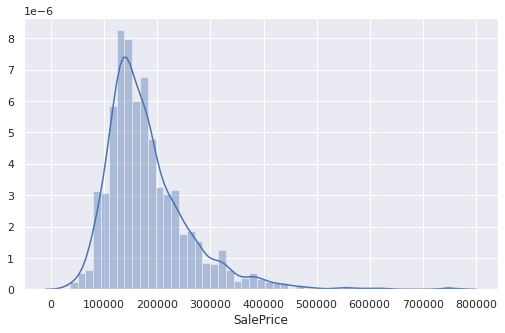

In [4]:
# plot distribution of SalePrice
f, ax = plt.subplots(figsize=(8.5, 5))
sns.distplot(df_train['SalePrice']);

#### Cleaning the Data:

In order to understand what type of data cleaning is required, I will evaluate the NaN's that are present in the data. When linear regression is run on a dataset, by default if a value in the dataframe is missing the whole row associated with it is removed from the model. If a high number of NaN's are present it reduces the efficacy of the model, as the resulting model no longer closely relates to the training data.  

To eliminate the likelihood of this occuring and ultimately skewing the model, I will look at the percentage and count of each column's missing values. 

In [5]:
# print table of missing data, count and percent, of each column
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


The columns with missing data are shown above. From this table, the easiest information to recognize and resolve is the columns with highly significant portions of their data missing: PoolQC, MiscFeature, Alley, Fence, and FireplaceQu. I chose to drop any columns with over 80% of their data missing, the high quantity of missing data signals insignificance in the model. 

For the remaining columns with data missing, we can see there is overlap with other columns/home-categories in the dataset - in the above dataset this means columns relating specifically to the Garage and Basement. I know that such high overlap between factors of a model will cause the data to overfit or muddy the results so I also chose to drop these columns from the model. Ultimately, any importance these columns would hold in the model will still remain via other columns. The only column within the above dataset that cannot be removed due to high-quantity of missing data or variable overlap is Electrical. It is within its own category of home factors, so I chose to take a different approach to managing the missing data as opposed to simply dropping the column all together. Only a single datapoint is missing so I chose to simply remove the row associated with it from the dataset. 

The final result of cleaning the data is that the 18 columns of least significance have been dropped and only a single row has been removed, leaving 1458 pieces of data for further analysis/potential addition to the final regression model

In [6]:
# drop missing data that has above 80% of its data missing 
df_train = df_train.drop((missing_data[missing_data['Percent'] > 0.8]).index,1)
# rebuild missing data without those values 
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# drop the data that has overlapping parameters
df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1, inplace=True)
# drop rows of NaN data from Electrical column
df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index, inplace=True)

#### Exploratory Data Analysis:

In order to understand how the remaining data correlates to one another I created a heatmap. The warmer colors (pink) relate to high correlation, and the cooler colors (cerulean) relate to low correlation. The first heatmap below shows the correlation between all variables, and the second heatmap is filtered to show the correlation between all the variables and 'SalePrice': the variable that our model is looking to ultimately predict.

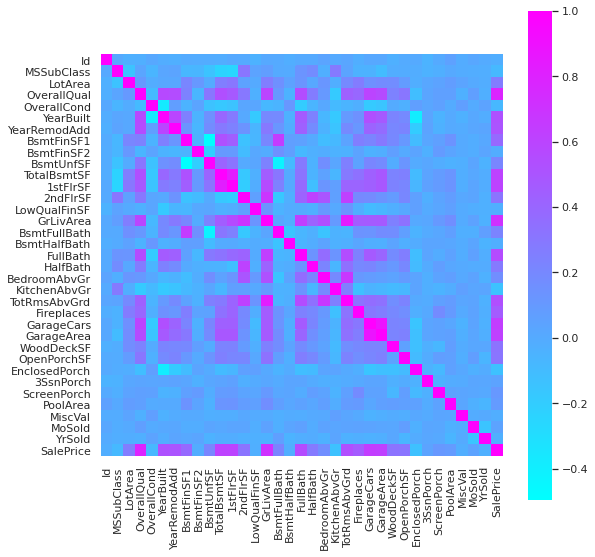

In [7]:
# correlation matrix for all remaining columns in df_train
correlation_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(correlation_matrix, square=True, cmap = 'cool');

After looking at the overall correlation between all variables with the dataset, I wanted to find out which variables had high levels of correlation to each other. My goal in determining this was to remove any columns that had high correlation and would skew the model. In order to do this I set a threshold of 60% correlated and then chose the column with the lowest correlation to 'SalePrice' to drop from the model. 

In [8]:
col_corr = [] # array of all the names of to be deleted columns
for i in range(len(correlation_matrix.columns[:])): # loop through all rows and columns of correlation matrix
    for j in range(i):
        # if value has not been evaluated yet and has high correlation 
        if (correlation_matrix.iloc[i, j] >= 0.7) and (correlation_matrix.columns[j] not in col_corr):
            colname = correlation_matrix.columns[i] # get the name of column
            rowname = correlation_matrix.columns[j] # get name of row
            if colname != 'SalePrice' and rowname != 'SalePrice': # not SalePrice
                # find correlation to SalePrice
                col_vs_SalePrice = correlation_matrix.iloc[i, -1] 
                row_vs_SalePrice = correlation_matrix.iloc[j, -1]
                # chose row or col that has highest correlation to SalePrice
                if col_vs_SalePrice > row_vs_SalePrice: 
                    col_corr.append(rowname)
                else:
                    col_corr.append(colname)
for col in col_corr:
    df_train.drop([col], axis=1, inplace=True) # delete the highly correlated columns

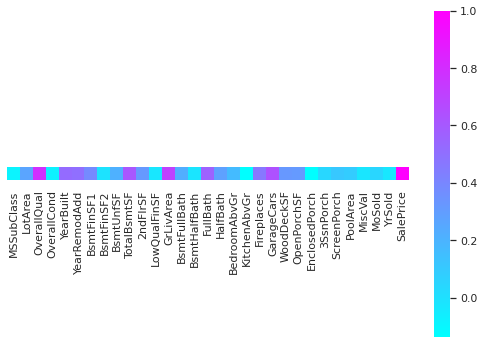

In [9]:
# print correlation matrix of all remaining columns, filtered to SalPrice row
correlation_matrix = df_train.corr()
corr = df_train[df_train.columns[1:]].corr()['SalePrice'][:]
data = np.asarray([corr]);
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data, square=True, xticklabels=corr.index, yticklabels='',  cmap = 'cool');

Evaluating the above correlation heatmap: the factors that seem to have the highest correlation to 'SalePrice' are 'OverallQual', GrLivArea', 'GarageCars'. And in order to understand their correlation to other variables and 'SalePrice' further, I zoomed into the portion of the correlation matrix that shows the 10 variables that most closely correlated to 'SalePrice' as well as anotated each correlation with the respective correlation coefficient. The goal of this visualization was to understand where there were potential overlaps of data that is highly correlated to 'SalePrice' due to the fact that overlap in data categories has been a continuing theme.

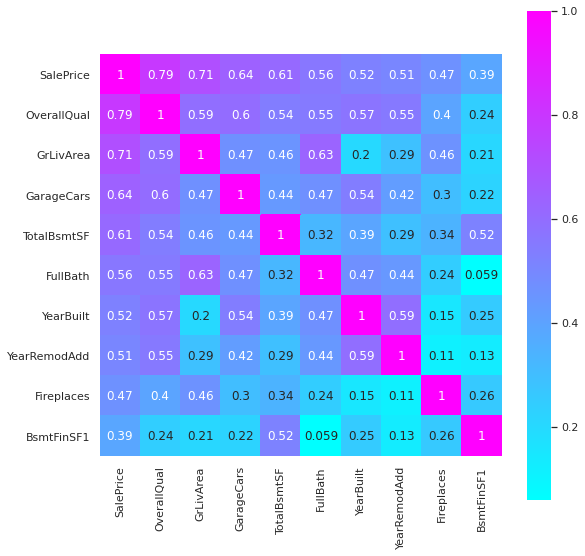

In [10]:
# zoom in on the variables correlated to just 'SalePrice'
f, ax = plt.subplots(figsize=(9, 9))
k = 10 # number of variables for subset heatmap
cols = correlation_matrix.nlargest(k, 'SalePrice')['SalePrice'].index  # select k highest-correlations from above correlation matrix
cm = np.corrcoef(df_train[cols].values.T) # calculate their correlation coefficients 
hm = sns.heatmap(cm, annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values, cmap = 'cool') 
plt.show()

To further understand how these key indicator variables (as found above) relate to one another, I created a pairplot.

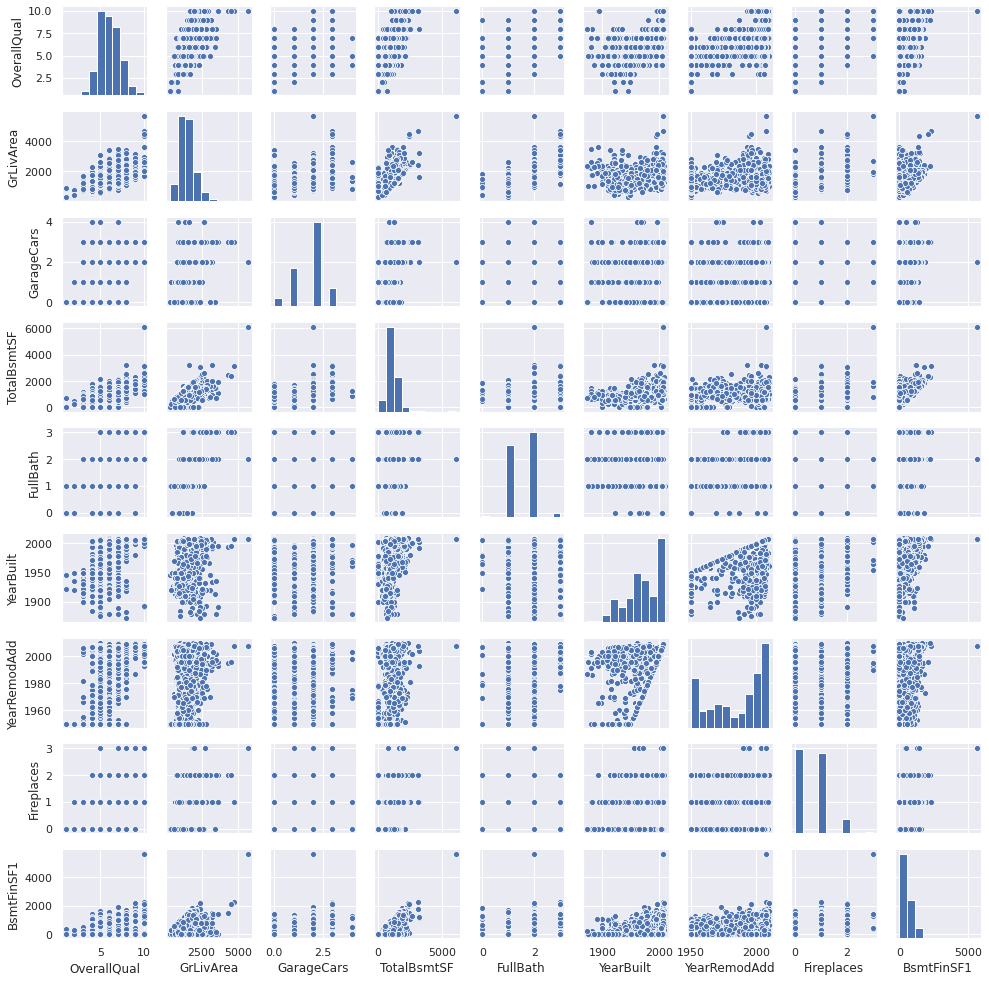

In [11]:
# create pairplot of parameters in above correlation matrix
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath','YearBuilt', 'YearRemodAdd', 'Fireplaces', 'BsmtFinSF1']
sns.pairplot(df_train[cols], height=1.5)
plt.show();

**Learnings from the pairplot:** The number of cars in garages and number of full baths in homes operates in integer values (thus the striped graphs) and is expected. The most common number of spots in a garage is 2 and the most common number of full pbaths is 1 or 2. The number of baths in homes does not increase depending on the year that the home was built, nor does the number of car spaces in garages. No remodels occurred before the home was built (obviously), but as a whole, the quantity  of remodels increased during recent years, as did the quantity of homes being built. The 'GrLivArea' stays flat as the year increases and with remodel; shows that the size of houses stays fairly constant. 'OverallQual' is positively correlated with 'TotalBsmtST', 'GarageCars', 'FullBath', 'YearBuilt', and 'YearRemodAdd', which shows that all these factors relate to the overall qualities that a buyer finds attractive when buying a home. 

#### Models:

Based on the title of the Kaggle competition, it was easy to select a regression model as the foundation of my model creation. I chose a linear regression model because the outcome (in this model the SalePrice) is continuous, house prices can be any value, while a logistic regression model would set a lower and upper bound on the results of SalePrice. Furthermore, the variables utilized in the model are a combination of continuous and categorical variables, and linear regression is best designed to support these inputs. 

Some factors that I will need to be aware of when building the model is that because the OLS method attemps to minimize errors and find the best possible fit, any large errors that are found are penalized quadratically. After running an initial model and fitting it, it will be necessary to go through the data and remove outliers. 

**Evaluative Regression Plot:** I wanted to see what type of accuracy and results my data exploration so far would return.

In [12]:
# run linear regression model on selected variables from correlation matrix
model_trn = smf.ols(formula='SalePrice~OverallQual+GrLivArea+GarageCars+TotalBsmtSF+FullBath+YearBuilt+YearRemodAdd+Fireplaces+BsmtFinSF1', data=df_train).fit()
model_trn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     588.7
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:19:40   Log-Likelihood:                -17410.
No. Observations:                1459   AIC:                         3.484e+04
Df Residuals:                    1449   BIC:                         3.489e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.125e+06   1.26e+05     -8.930      0.000   -1.37e+06   -8.78e+05
OverallQual   1.898e+04   1169.195     16.232      0.000    1.67e+04    2.13e+04
GrLivArea       48.2403      3.009     16.034      0.000      42.339      54.142
GarageCars    1.406e+04   1760.754      7.987      0.000    1.06e+04    1.75e+04
TotalBsmtSF     18.4614      3.067      6.019      0.000      12.444      24.478
FullBath     -2119.7967   2622.665     -0.808      0.419   -7264.422    3024.829
YearBuilt      201.2831     49.351      4.079      0.000     104.476     298.091
YearRemodAdd   335.1648     62.316      5.378      0.000     212.925     457.405
Fireplaces    8367.9269   1764.116      4.743      0.000    4907.433    1.18e+04
BsmtFinSF1      19.3379      2.566      7.537      0.000      14.305      24.371
==============================================================================
Omnibus:                      630.587   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99758.208
Skew:                          -0.917   Prob(JB):                         0.00
Kurtosis:                      43.468   Cond. No.                     4.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results of this initial linear regression model show that all selected variables are useful to the model, all are variables have a p-value less than 0.05, and the r-squared value is 0.785. This is an excellent starting basis for creating a comprehensive linear regression model

Taking into account the final correlation matrix, where I compared the most highly correlated values to SalePrice to one another, and the above regression model where the second warning attributes to strong multicollinearity, I decided to apply the interaction term to the model. As seen above in the correlation matrix, there significant correlation between values in the correlation matrix, on average above 0.3, leading me to believe that each factor's impact on the model does not occur in a vaccuum and the effect of one variable depends on the value of another variable(s). 

As seen below, by applying the interaction term, a significant increase in the R-squared value is returned: this model gives an R-squared of 0.941 while the above model had and R-squared of 0.785. The change in value validates my belief that each variable's impact on the model is directly tied to the other factors of the model. 

In [13]:
# run linear regression model with interaction term of above regression model
model_trn2 = smf.ols(formula='SalePrice~OverallQual*GrLivArea*GarageCars*TotalBsmtSF*FullBath*YearBuilt*YearRemodAdd*Fireplaces*BsmtFinSF1', data=df_train).fit()
model_trn2.summary().tables[0]

Dep. Variable:,SalePrice,R-squared:,0.941
Model:,OLS,Adj. R-squared:,0.931
Method:,Least Squares,F-statistic:,92.22
Date:,"Mon, 07 Dec 2020",Prob (F-statistic):,0.00
Time:,20:19:41,Log-Likelihood:,-16471.
No. Observations:,1459,AIC:,3.337e+04
Df Residuals:,1244,BIC:,3.451e+04
Df Model:,214,,
Covariance Type:,nonrobust,,


*I only plotted the first table in the regression model in order to be space efficient.

**Dealing with Outliers:** as I stated above large errors in the model are penalized quadratically, so now that we have a model with significant R-squared value I will remove any outliers found within the model. 

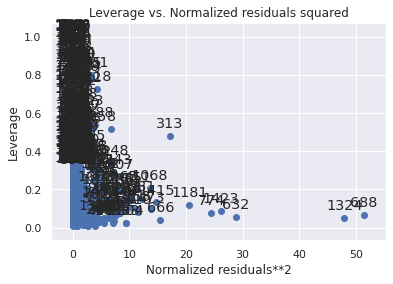

In [14]:
# plot leverage values 
sm.graphics.plot_leverage_resid2(model_trn2, alpha=0.05);

In [15]:
# drop outliers show in above model 
df_train.drop(df_train.index[688], inplace = True)
df_train.drop(df_train.index[1181], inplace = True)
df_train.drop(df_train.index[632], inplace = True)
df_train.drop(df_train.index[1423], inplace = True)
df_train.drop(df_train.index[313], inplace = True)
df_train.drop(df_train.index[774], inplace = True)

In [16]:
# rerun model without outliers with interaction term
model_trn3 = smf.ols(formula='SalePrice~OverallQual*GrLivArea*GarageCars*TotalBsmtSF*FullBath*YearBuilt*YearRemodAdd*Fireplaces*BsmtFinSF1', data=df_train).fit()
model_trn3.summary().tables[0]

Dep. Variable:,SalePrice,R-squared:,0.943
Model:,OLS,Adj. R-squared:,0.933
Method:,Least Squares,F-statistic:,95.54
Date:,"Mon, 07 Dec 2020",Prob (F-statistic):,0.00
Time:,20:19:44,Log-Likelihood:,-16345.
No. Observations:,1453,AIC:,3.312e+04
Df Residuals:,1238,BIC:,3.426e+04
Df Model:,214,,
Covariance Type:,nonrobust,,


##### Forward Stepwise Refinement:

While I am happy with the R-squared value that we have thus so far. I want to apply forward stepwise refinement on the data, to verify that such model would not benefit from less factors being applied. Ultimately the goal is to find the least amount of factors that give the best model, so that it is flexible enough to be applied to other datasets, and lessens the chance of overfitting.

In order to build out such model, I created a training and a testing set, each  dataset containing 1000 randomly selected samples derived from the df_train dataset using np.random.choice. I will manually perform the steps of the *forward stepwise selection* method for all 9 parameters in our previous model, and based on the increments of the adjusted R-squared value I will be able to understand whether each parameter adds value to the overall model

In [17]:
# split df_train into testing and training sets via random choice
tf = np.random.choice(df_train.index, replace=True, size=1000)
test = df_train.loc[tf]
trainf = np.random.choice(df_train.index, replace=True, size=1000)
train = df_train.loc[trainf]
# allowed factors that can be selected in stepwise refinement
allowed_factors = ['OverallQual', 'GrLivArea','GarageCars','TotalBsmtSF',
                   'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'BsmtFinSF1']

In [18]:
# k = 1 choice 
k1_r = -1000000
k1_factor = ''
for factor in allowed_factors: # loop through allowed factors
    model1 = smf.ols(formula='SalePrice~' + factor, data=train).fit(); # run regression model with such factor
    if model1.rsquared_adj > k1_r: # if the adjusted r-squared is higher, save factor and r-squared val
        k1_r = model1.rsquared_adj
        k1_factor = factor
print('Best Adjusted R-squared:', k1_r, 'Selected Factor:', k1_factor) # return selected factor and adj r-squared

Best Adjusted R-squared: 0.6410220923574266 Selected Factor: OverallQual


In [19]:
# k = 2 choice 
k2_r = -1000000
k2_factor = ''
k2_allowed = allowed_factors 
k2_allowed.remove(k1_factor)
for factor in k2_allowed: 
    model2 = smf.ols(formula='SalePrice~' + k1_factor + '*' + factor, data=train).fit();
    if model2.rsquared_adj > k2_r: 
        k2_r = model2.rsquared_adj
        k2_factor = factor
print('Best Adjusted R-squared:', k2_r, 'Selected Factor:', k2_factor)

Best Adjusted R-squared: 0.8189613944522454 Selected Factor: GrLivArea


In [20]:
# k = 3 choice 
k3_r = -1000000
k4_factor = ''
k3_allowed = k2_allowed 
k3_allowed.remove(k2_factor)
for factor in k3_allowed: 
    model3 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor  + '*' + factor, data=train).fit();
    if model3.rsquared_adj > k3_r: 
        k3_r = model3.rsquared_adj
        k3_factor = factor
print('Best Adjusted R-squared:', k3_r, 'Selected Factor:', k3_factor)

Best Adjusted R-squared: 0.8567324370239281 Selected Factor: TotalBsmtSF


In [21]:
# k = 4 choice 
k4_r = -1000000
k4_factor = ''
k4_allowed = k3_allowed 
k4_allowed.remove(k3_factor)
for factor in k4_allowed: 
    model4 = smf.ols(formula='SalePrice~'+ k1_factor  + '*' + k2_factor + '*' + k3_factor + '*' + factor, data=train).fit();
    if model4.rsquared_adj > k4_r: 
        k4_r = model4.rsquared_adj
        k4_factor = factor
print('Best Adjusted R-squared:', k4_r, 'Selected Factor:', k4_factor)

Best Adjusted R-squared: 0.8807727269753657 Selected Factor: YearBuilt


In [22]:
# k = 5 choice 
k5_r = -1000000
k5_factor = ''
k5_allowed = k4_allowed 
k5_allowed.remove(k4_factor)
for factor in k5_allowed: 
    model5 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + factor, data=train).fit();
    if model5.rsquared_adj > k5_r: 
        k5_r = model5.rsquared_adj
        k5_factor = factor
print('Best Adjusted R-squared:', k5_r, 'Selected Factor:', k5_factor)

Best Adjusted R-squared: 0.9034513079699795 Selected Factor: BsmtFinSF1


In [23]:
# k = 6 choice 
k6_r = -1000000
k6_factor = ''
k6_allowed = k5_allowed 
k6_allowed.remove(k5_factor)
for factor in k6_allowed: 
    model6 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + 
                    factor, data=train).fit();
    if model6.rsquared_adj > k6_r: 
        k6_r = model6.rsquared_adj
        k6_factor = factor
print('Best Adjusted R-squared:', k6_r, 'Selected Factor:', k6_factor)

Best Adjusted R-squared: 0.9170843522196593 Selected Factor: YearRemodAdd


In [24]:
# k = 7 choice 
k7_r = -1000000
k7_factor = ''
k7_allowed = k6_allowed 
k7_allowed.remove(k6_factor)
for factor in k7_allowed: 
    model7 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    factor, data=train).fit();
    if model7.rsquared_adj > k7_r: 
        k7_r = model7.rsquared_adj
        k7_factor = factor
print('Best Adjusted R-squared:', k7_r, 'Selected Factor:', k7_factor)

Best Adjusted R-squared: 0.9276948097629832 Selected Factor: FullBath


In [25]:
# k = 8 choice 
k8_r = -1000000
k8_factor = ''
k8_allowed = k7_allowed 
k8_allowed.remove(k7_factor)
for factor in k8_allowed: 
    model8 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    k7_factor + '*' + factor, data=train).fit();
    if model8.rsquared_adj > k8_r: 
        k8_r = model8.rsquared_adj
        k8_factor = factor
print('Best Adjusted R-squared:', k8_r, 'Selected Factor:', k8_factor)

Best Adjusted R-squared: 0.9390093244234653 Selected Factor: Fireplaces


In [26]:
# k = 9 choice 
k9_r = -1000000
k9_factor = ''
k9_allowed = k8_allowed 
k9_allowed.remove(k8_factor)
for factor in k9_allowed: 
    model9 = smf.ols(formula='SalePrice~'+ k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    k7_factor + '*' + k8_factor + '*' + factor, data=train).fit();
    if model9.rsquared_adj > k9_r: 
        k9_r = model9.rsquared_adj
        k9_factor = factor
print('Best Adjusted R-squared:', k9_r, 'Selected Factor:', k9_factor)

Best Adjusted R-squared: 0.953862870079791 Selected Factor: GarageCars


After completing forward stepwise selection on each parameter, I ran the selected parameters agains the test dataset, and plotted the results from both the testing and training data.

In [27]:
# run selected factors against the test data in order, return their adjusted r-square vals for each factor added 
model_1 = smf.ols(formula='SalePrice~' + factor, data=test).fit();
model_2 = smf.ols(formula='SalePrice~' + k1_factor + '*' + factor, data=test).fit();
model_3 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + factor, data=test).fit();
model_4 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + factor, data=test).fit();
model_5 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + factor, data=test).fit();
model_6 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + 
                    factor, data=test).fit();
model_7 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    factor, data=test).fit();
model_8 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    k7_factor + '*' + factor, data=test).fit();
model_9 = smf.ols(formula='SalePrice~' + k1_factor + '*' + k2_factor + '*' + k3_factor + '*' + k4_factor + '*' + k5_factor + '*' + k6_factor + '*' + 
                    k7_factor + '*' + k8_factor + '*' + factor, data=test).fit();
test_adj_r = [model_1.rsquared_adj, model_2.rsquared_adj, model_3.rsquared_adj, model_4.rsquared_adj, model_5.rsquared_adj, model_6.rsquared_adj, model_7.rsquared_adj, model_8.rsquared_adj, model_9.rsquared_adj]

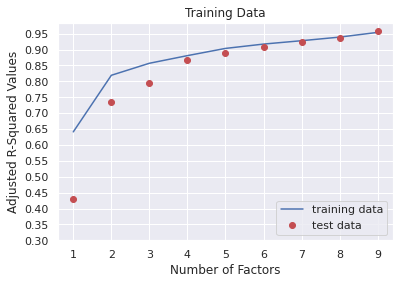

In [28]:
# plot model adjusted r-squared vs test adjusted r-squared
adj_r = [k1_r, k2_r, k3_r, k4_r, k5_r, k6_r, k7_r, k8_r, k9_r]
k_val = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.plot(k_val, adj_r, label='training data');
plt.plot(k_val, test_adj_r, 'ro', label='test data');
plt.yticks(np.arange(0.3, 1.0, 0.05));
plt.xticks(np.arange(1, 10, 1));
plt.xlabel('Number of Factors')
plt.ylabel('Adjusted R-Squared Values')
plt.title('Training Data');
plt.legend(loc="lower right");

The results from the Forward Stepwise Refinement model validate the use of the parameters in the above linear regression, from Forward Stepwised Refinement model we are able to learn that each parameter in the model builds upon one another supporting the overall accuracy of the model. Based on the plot of the training vs testing model, I would reccommend using all parameters in the overall model, due to the randomized nature of how I split up the testing and training data, I was able to re-run the model multiple times and get different plots, in all models as the number of parameters increased the closer the adjusted R-squared value of the testing data got to the training data.

#### Results & Analysis:

**Summmary:** The final results give me a conservative 94.5% efficacy, and have been validated by both a linear regression model and the used of forward stepwise refinement. As stated above I chose linear regression because the goal parameter (in this model the SalePrice) is continuous, house prices can be any value, while a logistic regression model would set a lower and upper bound on the results of SalePrice. Furthermore, the variables utilized in the model are a combination of continuous and categorical variables, and of the models, we learned in class linear regression is best designed to support these inputs. It also can handle any skew in the data, which was visible when I plotted the distribution of SalePrice. 

Before deciding on any model, I decided to drop columns of data that were missing high-quantities of variables, above 80%, and of the remaining parameters with missing values, if they had a comparable metric in the model without missing data, drop it, and if not drop the NaN variables. This enabled simple/efficient cleaning and a way to start out simplifying the model.

While I decided upon the models that I was going to use at the beginning of the project, what is represented here is the second try at getting an accurate model. The first time I ran through the modeling process, I did not take multicolinearity into account and attempted to perform forward stepwise regression on all of the variables in the model. After building the process out for 20 parameters, my model efficacy was just higher than the above attempt to run regression with out factoring in the interaction term (R-squared of 0.785). While the R-squared was okay, the large quantity of variables it required, showed me that I had an overcomplicated the model. Once I realized that I had gone in the wrong direction in terms of creating a scalable model. 

**Starting over:** I went all the way back to the beginning with the goal to reduce the presence of colinear and highly-correlated variables within the model. As I explained above: parameters that have high correlation, do not add enough unique value to the model to off-set the complications the multicolinearity. In order to determine this I created a correlation matrix and dropped one of any variables with a correlation of 0.7 or above, the variable being dropped was the one with the lowest correlation to SalePrice. From there I looked at the top parameters with highest correlation to SalePrice and built out my model using only those parameters. A simple linear regression model of these parameters gave a r-squared value of 0.785, but high correlation between the variables in the model, led me to test their efficacy as an interaction term, which resulted in an r-squared value of 0.941. At this point I looked for/removed outliers that could unproportionately affect the results, and finished my evaluation with the use of a forward stepwise refinement model, while I had a good r-squared value, I wanted to verify that all parameters were valuable to the model and did not have any factors that did not add value. My number of variables in the model was validated via the stepwise refinement, as the model had the highest efficacy (and growth was seen between each additional factor). 

Improvements: While I chose to utilize evaluation methods that we learned in class to build my model, I think there could be some improvement when utilizing a more advance modeling techniques. Dealing with multicolinearity was challenging with my current techique and thus I could have utilized a LASSO regression to avoid multicollinearity. In addition there are advanced machine-learning modeling tools that would have resulted in near accuracy. However, my goal in completing this project was to apply the tools we practiced over the course of the semester to come up with a model with the highest efficacy possible. 


Code to export predicted SalePrice for Kaggle submission: 

In [35]:
# export results of model on test data, to csv for Kaggle submission
df_test = pd.read_csv('test.csv')
predicted_price = []
for pred in model_trn3.predict(df_test):
    predicted_price.append(pred)
ids = []
for i in df_test['Id']:
    ids.append(i)
df_result = pd.DataFrame({'Id': ids, 'SalePrice': predicted_price});
df_result.to_csv('submission.csv', index=False)